In [1]:
#Quantum Circuit Born Machine 
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

num_qubits = 8
num_layers = 2
num_samples = 1000

dev = qml.device("default.qubit", wires=num_qubits, shots=num_samples)

def qcbm_ansatz(params):
    param_idx = 0
    for layer in range(num_layers):

        for qubit in range(num_qubits):
            qml.RY(params[param_idx], wires=qubit)
            param_idx += 1

        for qubit in range(num_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])

# Quantum circuit definition
@qml.qnode(dev)
def circuit(params, basis="computational"):
    qcbm_ansatz(params)

    if basis == "Y":
        for qubit in range(num_qubits):
            qml.RX(np.pi / 2, wires=qubit)


    return qml.sample()

num_params = num_qubits * num_layers
params = np.random.uniform(0, 2 * np.pi, num_params)


samples_computational = circuit(params, basis="computational")
samples_Y_basis = circuit(params, basis="Y")

# Print sample outputs
print("Samples in computational basis:")
print(samples_computational)

print("\nSamples in Y-basis:")
print(samples_Y_basis)


def plot_sample_distribution(samples, title):
    counts = {}
    for sample in samples:
        bitstring = ''.join(str(int(bit)) for bit in sample)
        counts[bitstring] = counts.get(bitstring, 0) + 1
    
    sorted_counts = dict(sorted(counts.items()))

    plt.figure(figsize=(12, 4))
    plt.bar(sorted_counts.keys(), sorted_counts.values(), color='navy')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel("Bitstrings")
    plt.ylabel("Counts")
    plt.show()

# Visualize results
plot_sample_distribution(samples_computational, "QCBM Samples in Computational Basis")
plot_sample_distribution(samples_Y_basis, "QCBM Samples in Y-Basis")

ModuleNotFoundError: No module named 'pennylane'

/opt/anaconda3/lib/python3.12/site-packages/pennylane/_grad.py:216: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


Step 0: KL divergence = 12.9274
Step 10: KL divergence = 13.3106
Step 20: KL divergence = 12.6873
Step 30: KL divergence = 12.6982
Step 40: KL divergence = 13.3447
Step 50: KL divergence = 13.1714
Step 60: KL divergence = 12.8067
Step 70: KL divergence = 12.6991
Step 80: KL divergence = 12.7043
Step 90: KL divergence = 12.9905
Step 100: KL divergence = 13.0073
Step 110: KL divergence = 13.1022
Step 120: KL divergence = 12.7391
Step 130: KL divergence = 13.0012
Step 140: KL divergence = 13.0730
Step 150: KL divergence = 12.6965
Step 160: KL divergence = 12.9876
Step 170: KL divergence = 12.6906
Step 180: KL divergence = 13.1570
Step 190: KL divergence = 13.3364


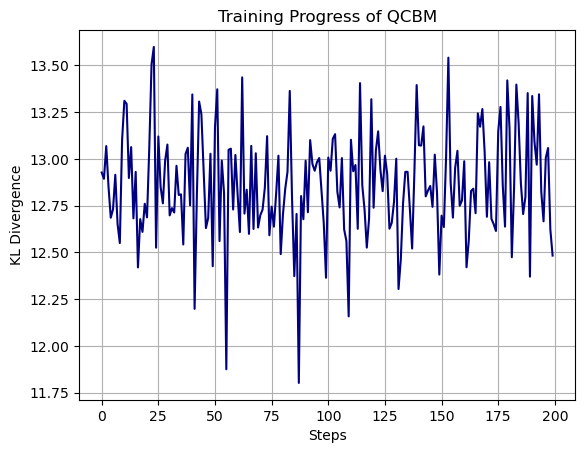

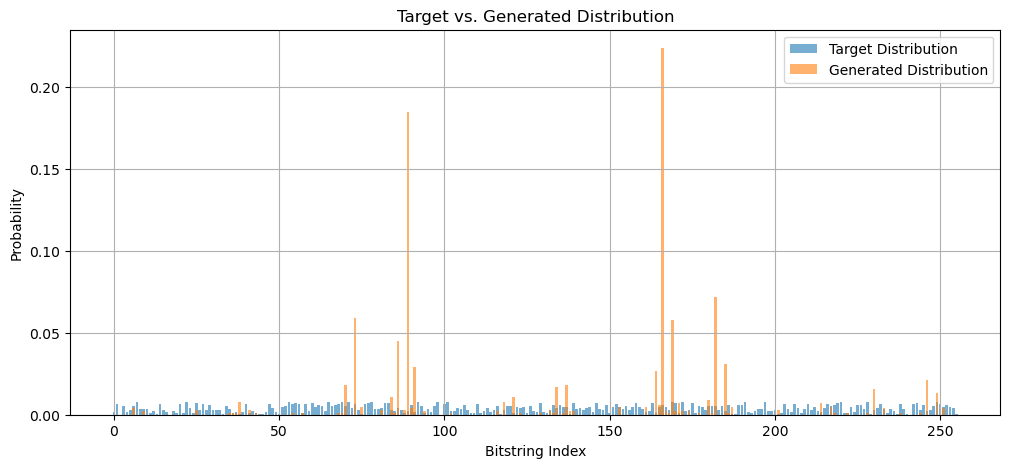

In [2]:
#using an  optimizer 

import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

# Set parameters
num_qubits = 8
num_layers = 2
num_samples = 1000
steps = 200
learning_rate = 0.1


dev = qml.device("default.qubit", wires=num_qubits, shots=num_samples)

def qcbm_ansatz(params):
    param_idx = 0
    for layer in range(num_layers):
        # Rotation layer
        for qubit in range(num_qubits):
            qml.RY(params[param_idx], wires=qubit)
            param_idx += 1

        # Entangling layer (nearest-neighbor CNOTs)
        for qubit in range(num_qubits - 1):
            qml.CNOT(wires=[qubit, qubit + 1])


@qml.qnode(dev)
def circuit(params):
    qcbm_ansatz(params)
    return qml.probs(wires=range(num_qubits))


target_distribution = np.random.rand(2 ** num_qubits)
target_distribution /= np.sum(target_distribution)  


def cost(params):
    generated_distribution = circuit(params)
    kl_divergence = np.sum(target_distribution * np.log(target_distribution / (generated_distribution + 1e-10)))
    return kl_divergence

num_params = num_qubits * num_layers
params = np.random.uniform(0, 2 * np.pi, num_params)


opt = qml.AdamOptimizer(learning_rate)

cost_progress = []
for step in range(steps):
    params, current_cost = opt.step_and_cost(cost, params)
    cost_progress.append(current_cost)
    if step % 10 == 0:
        print(f"Step {step}: KL divergence = {current_cost:.4f}")


plt.plot(cost_progress, color='navy')
plt.xlabel("Steps")
plt.ylabel("KL Divergence")
plt.title("Training Progress of QCBM")
plt.grid()
plt.show()


final_distribution = circuit(params)


plt.figure(figsize=(12, 5))
plt.bar(np.arange(2 ** num_qubits), target_distribution, alpha=0.6, label='Target Distribution')
plt.bar(np.arange(2 ** num_qubits), final_distribution, alpha=0.6, label='Generated Distribution')
plt.xlabel("Bitstring Index")
plt.ylabel("Probability")
plt.title("Target vs. Generated Distribution")
plt.legend()
plt.grid()
plt.show()


In [5]:
import pennylane as qml
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# Quantum Parameters
num_qubits = 8
num_layers = 2
dev = qml.device("default.qubit", wires=num_qubits, shots=1000)

# QCBM quantum circuit ansatz
def qcbm_ansatz(params):
    idx = 0
    for _ in range(num_layers):
        for q in range(num_qubits):
            qml.RY(params[idx], wires=q)
            idx += 1
        for q in range(num_qubits - 1):
            qml.CNOT(wires=[q, q+1])

# Quantum circuit definition with probability outputs
@qml.qnode(dev, interface='torch')
def circuit(params):
    qcbm_ansatz(params)
    return qml.probs(wires=range(num_qubits))

# Classical GAN models (simple architecture)
class Generator(nn.Module):
    def __init__(self, latent_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(latent_dim, 128), nn.ReLU(),
            nn.Linear(128, img_dim), nn.Sigmoid()
        )

    def forward(self, z):
        return self.gen(z)

class Discriminator(nn.Module):
    def __init__(self, img_dim, latent_dim):
        super().__init__()
        self.latent = nn.Sequential(nn.Linear(img_dim, latent_dim), nn.ReLU())
        self.output = nn.Sequential(nn.Linear(latent_dim, 1), nn.Sigmoid())

    def forward(self, x):
        latent_space = self.latent(x)
        validity = self.output(latent_space)
        return validity, latent_space

# Setup GAN
latent_dim = 2 ** num_qubits  # =256 for 8 qubits
img_dim = 28 * 28
G = Generator(latent_dim, img_dim)
D = Discriminator(img_dim, latent_dim)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)

# MNIST Data Loader
dataset = MNIST(root='./data', train=True, download=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize QCBM parameters explicitly trainable
num_params = num_layers * num_qubits
qcbm_params = torch.randn(num_params, requires_grad=True)

# Optimizer for QCBM
qcbm_optimizer = optim.Adam([qcbm_params], lr=0.1)

# Hybrid Training Loop
for epoch in range(5):  # just 5 epochs for demo purposes
    for real_imgs, _ in loader:
        real_imgs = real_imgs.view(-1, img_dim)
        batch_size = real_imgs.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        z_noise = torch.randn(batch_size, latent_dim)
        fake_imgs = G(z_noise).detach()
        real_validity, real_latent = D(real_imgs)
        fake_validity, _ = D(fake_imgs)
        d_loss = (criterion(real_validity, torch.ones_like(real_validity)) +
                  criterion(fake_validity, torch.zeros_like(fake_validity))) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train QCBM to match GAN's latent distribution
        latent_target = torch.mean(real_latent, dim=0)
        latent_target = torch.softmax(latent_target, dim=0)

        qcbm_optimizer.zero_grad()
        generated_probs = circuit(qcbm_params)
        loss_qcbm = torch.sum(latent_target * torch.log((latent_target + 1e-8) / (generated_probs + 1e-8)))
        loss_qcbm.backward()
        qcbm_optimizer.step()

        # Generate quantum-informed priors
        with torch.no_grad():
            q_probs = circuit(qcbm_params).detach().numpy()
            q_samples = np.random.choice(2 ** latent_dim, p=q_probs, size=batch_size)
            q_prior = np.array([list(np.binary_repr(x, width=latent_dim)) for x in q_samples], dtype=np.float32)
            q_prior = torch.tensor(q_prior)

        # Train Generator with QCBM-informed prior
        optimizer_G.zero_grad()
        generated_imgs = G(q_prior)
        validity, _ = D(generated_imgs)
        g_loss = criterion(validity, torch.ones_like(validity))
        g_loss.backward()
        optimizer_G.step()

    print(f'Epoch [{epoch+1}/5] | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f} | QCBM_loss: {loss_qcbm.item():.4f}')

print("Hybrid Quantum-Classical training completed.")


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.